In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn import preprocessing
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix,f1_score
from sklearn.model_selection import KFold,cross_val_score,train_test_split,GridSearchCV,RandomizedSearchCV

In [2]:
fraud = pd.read_csv("/Fraud_check.csv")
fraud.rename(columns={"Marital.Status":"Marital_Status","Taxable.Income":"Taxable_Income",
                        "City.Population":"City_Population","Work.Experience":"Work_Experience"},inplace=True)
fraud.head()

,Undergrad,Marital_Status,Taxable_Income,City_Population,Work_Experience,Urban
0,NO,Single,68833,50047,10,YES
1,YES,Divorced,33700,134075,18,YES
2,NO,Married,36925,160205,30,YES
3,YES,Single,50190,193264,15,YES
4,NO,Married,81002,27533,28,NO


In [3]:
fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Undergrad        600 non-null    object
 1   Marital_Status   600 non-null    object
 2   Taxable_Income   600 non-null    int64 
 3   City_Population  600 non-null    int64 
 4   Work_Experience  600 non-null    int64 
 5   Urban            600 non-null    object
dtypes: int64(3), object(3)
memory usage: 28.2+ KB


In [4]:
fraud.describe()

,Taxable_Income,City_Population,Work_Experience
count,600.000000,600.000000,600.000000
mean,55208.375000,108747.368333,15.558333
std,26204.827597,49850.075134,8.842147
min,10003.000000,25779.000000,0.000000
25%,32871.500000,66966.750000,8.000000
50%,55074.500000,106493.500000,15.000000
75%,78611.750000,150114.250000,24.000000
max,99619.000000,199778.000000,30.000000


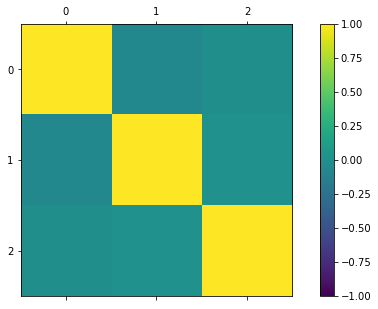

In [5]:
# correlation matrix
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
cax = ax.matshow(fraud.corr(), vmin=-1, vmax=1)
fig.colorbar(cax)
plt.show()

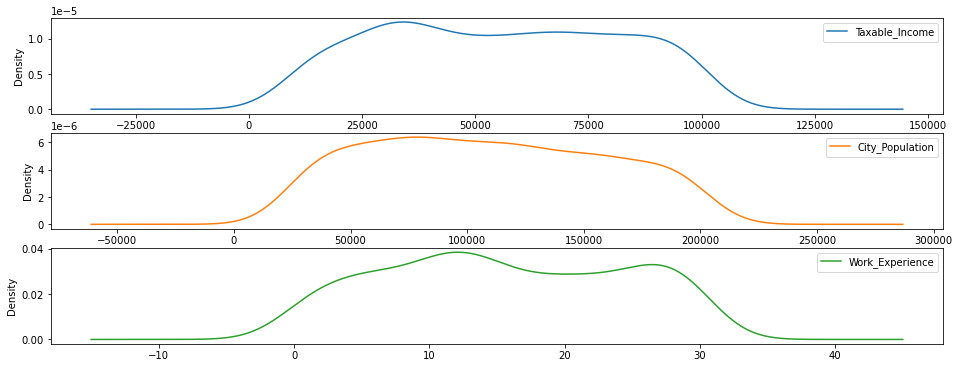

In [6]:
fraud.plot(kind="kde", subplots=True, layout=(3,1),sharex=False,figsize=(16,6))
plt.show()

In [7]:
#Creating a new Column for categorical taxable income value
fraud["taxable_income"]="Risky"
fraud.loc[fraud["Taxable_Income"]>=30000,"taxable_income"]="Good"
fraud.drop(["Taxable_Income"],axis=1,inplace=True)
print(fraud.shape)
fraud.head()

(600, 6)


,Undergrad,Marital_Status,City_Population,Work_Experience,Urban,taxable_income
0,NO,Single,50047,10,YES,Good
1,YES,Divorced,134075,18,YES,Good
2,NO,Married,160205,30,YES,Good
3,YES,Single,193264,15,YES,Good
4,NO,Married,27533,28,NO,Good


In [8]:
# applying lable encoder to taxable_income column and One Hot Encoding for other
label_encoder = preprocessing.LabelEncoder()
fraud["taxable_income"] = label_encoder.fit_transform(fraud["taxable_income"])
fraud = pd.get_dummies(fraud)
print(fraud.shape)
fraud.head()

(600, 10)


,City_Population,Work_Experience,taxable_income,Undergrad_NO,Undergrad_YES,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Urban_NO,Urban_YES
0,50047,10,0,1,0,0,0,1,0,1
1,134075,18,0,0,1,1,0,0,0,1
2,160205,30,0,1,0,0,1,0,0,1
3,193264,15,0,0,1,0,0,1,0,1
4,27533,28,0,1,0,0,1,0,1,0


In [9]:
# seprating x and y(class) variables 
X= pd.concat([fraud.iloc[:,0:2],fraud.iloc[:,3:]],axis = 1)
Y= fraud.iloc[:,2]

In [10]:
# Risky: 1 & Good: 0
Y.value_counts()

0    476
1    124
Name: taxable_income, dtype: int64

In [11]:
# Splitting data into training and testing data set
seed = 7
X_train,X_test,Y_train,Y_test = train_test_split(X,Y, test_size=0.30,random_state=seed)

In [12]:
#applying RF classifier with criteria and depth on train models
model = RandomForestClassifier(random_state=seed)
model.fit(X_train,Y_train)

RandomForestClassifier(random_state=7)

In [13]:
#Randomized search for hyper parameter
param_dict={"n_estimators":[50,70,90,100,200],"criterion":["entropy","gini"],"max_features":["auto","sqrt","log2"]}
grid = RandomizedSearchCV(model,param_dict,cv=10)
grid.fit(X_train,Y_train)
grid.best_params_,grid.best_score_

({'n_estimators': 70, 'max_features': 'log2', 'criterion': 'entropy'},
 0.7380952380952381)

In [14]:
#grid search for hyper parameter
param_dict={"n_estimators":[50,70,90,100,200],"criterion":["entropy","gini"],"max_features":["auto","sqrt","log2"]}
grid = GridSearchCV(model,param_grid=param_dict,cv=10)
grid.fit(X_train,Y_train)
grid.best_params_,grid.best_score_

({'criterion': 'entropy', 'max_features': 'auto', 'n_estimators': 50},
 0.7404761904761905)

**since the ratio of taxable income which is good and risky is uneven so less depth will prune the tree to pure nodes,
As grid search gives more accuracy we apply same parameters from GridSearchCV Results**

In [15]:
# applying RF classifier parameters on train models based on GridSearchCV Results
model = RandomForestClassifier(n_estimators = 50 ,criterion = "entropy",max_features = "auto" )
model.fit(X_train,Y_train)

RandomForestClassifier(criterion='entropy', n_estimators=50)

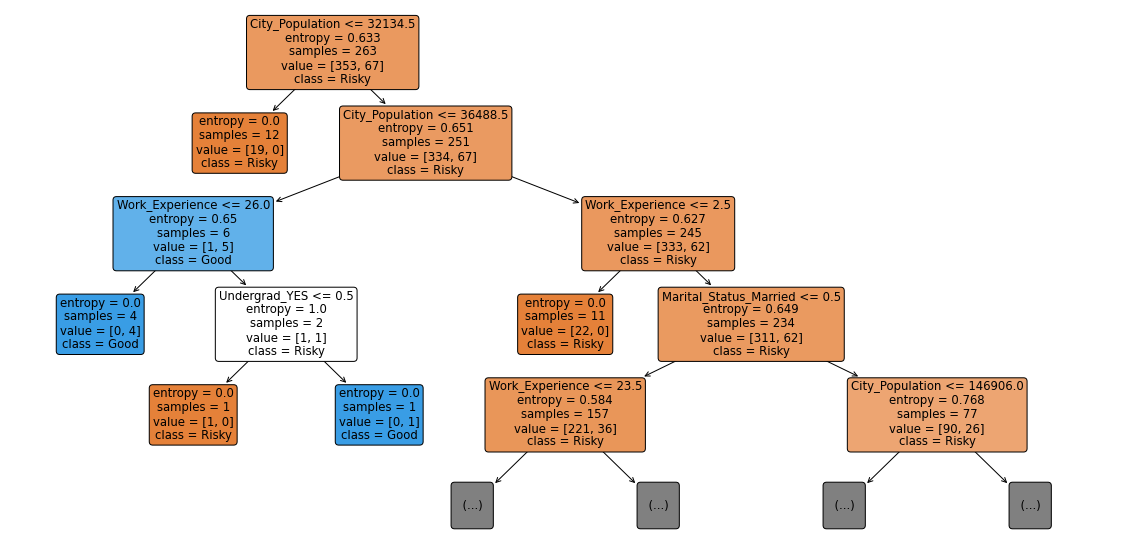

In [16]:
# first 3 roots of Tree
rf_best = grid.best_estimator_
plt.figure(figsize=(20,10))
plot_tree(rf_best.estimators_[5],max_depth=4,feature_names = X.columns, rounded=True,filled=True,class_names=["Risky", "Good"]);

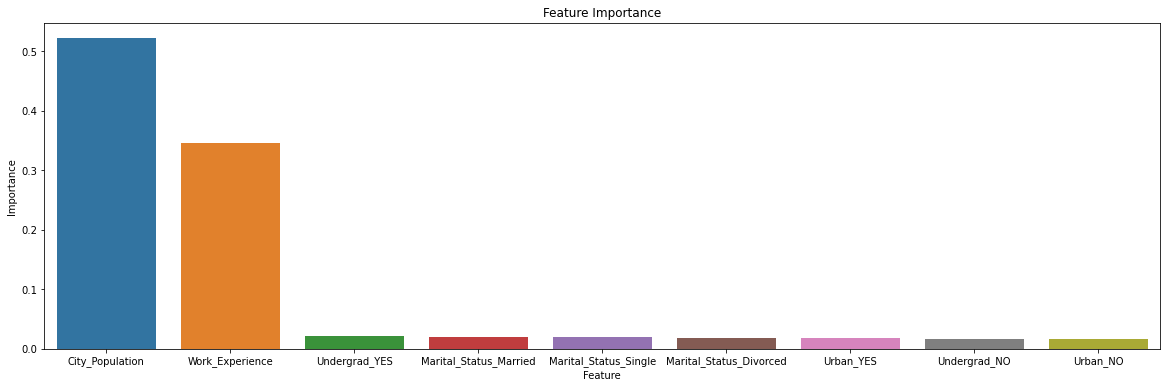

In [17]:
#listing and plotting features with their importance
imp_feat = pd.DataFrame({"Feature": X_train.columns,"Importance": rf_best.feature_importances_})
imp_feat = imp_feat.sort_values(by = "Importance", ascending = False)
plt.figure(figsize=(20,6))
plt.title("Feature Importance")
sns.barplot(y = "Importance", x = "Feature", data=imp_feat)
plt.show();

**It can be seen Population & Experience have a greater impact in predicting Taxable Income**

In [18]:
#Predicting on test data
preds = model.predict(X_test)
pd.Series(preds).value_counts()

0    174
1      6
dtype: int64

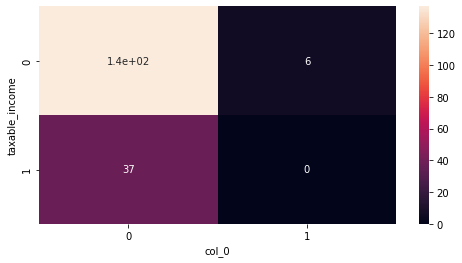

In [19]:
#Confusion Matrix
plt.figure(figsize=(8,4))
matrix = pd.crosstab(Y_test,preds)
sns.heatmap(matrix,annot=True);

In [20]:
#Accuracy using different methods
results = cross_val_score(model, X, Y, cv=10)
matrix = f1_score(Y_test, preds)
print("Mean cross_val_score -",round(results.mean()*100,2),"%",
      "\nY_test Accuracy -",round(np.mean(preds==Y_test)*100,2),"%")

Mean cross_val_score - 72.83 % 
Y_test Accuracy - 76.11 %


**An Average Accuracy above 75% is achived which makes the model good and useful for future predictions**